In [12]:
import openeo
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# Establish the connetion to openeo
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [8]:
# Define the datacube to acquire
so2_cube = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=("2022-05-01", "2022-05-30"),
    spatial_extent={
        "west": 13.7,
        "south": 38,
        "east": 16.6,
        "north": 40,
        "crs": "EPSG:4326",
    },
    bands=["SO2"]
)

In [9]:
# Get the datacube
so2_cube.download("stromboli_so2_data.nc")

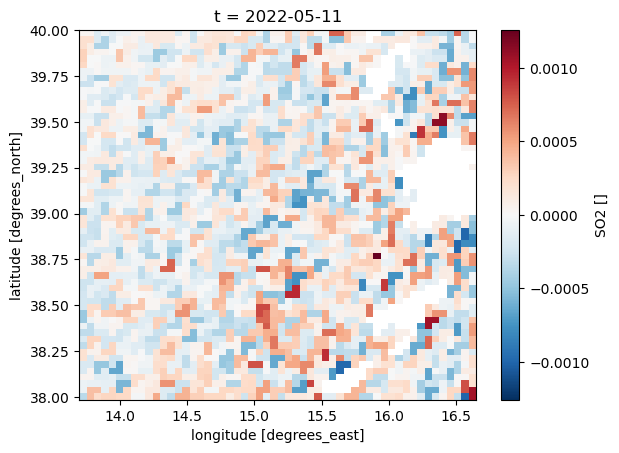

In [17]:
# Open the file
with xr.open_dataset('stromboli_so2_data.nc') as ds:

    # Calculate the region mask
    
    
    ds.SO2.isel(t=10).plot()